<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/Ali/Time_Series_Labelling_beta_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Libraries

In [ ]:
# Import Libraries 
!pip install hmmlearn
import itertools as itt
import numbers
import numpy as np
import pandas as pd
from abc import abstractmethod
from typing import Iterable, Tuple, List
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import TimeSeriesSplit

     |████████████████████████████████| 374 kB 6.3 MB/s 


# Functions

In [ ]:
# Labelling algorithm X is price and w is our threshould

def labeling(X, w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh, HT, cid = X[i], i, 1
    return y

In [ ]:
# Implement Cross-validation methods

class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class PurgedWalkForwardCV(BaseTimeSeriesCrossValidator):
  """
  Purged walk-forward cross-validation
  As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
  The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
  validation round, n_test_splits contiguous folds are used as the test set, while the train set consists in between
  min_train_splits and max_train_splits immediately preceding folds.
  Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
  that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
  overlapping samples are dropped.)
  With split_by_times = True in the split method, it is also possible to split the samples in folds spanning equal
  time intervals (using the prediction time as a time tag), instead of folds containing equal numbers of samples.
  Parameters
  ----------
  n_splits : int, default=10
      Number of folds. Must be at least 2.
  n_test_splits : int, default = 1
      Number of folds used in the test set. Must be at least 1.
  min_train_splits: int, default = 2
      Minimal number of folds to be used in the train set.
  max_train_splits: int, default = None
      Maximal number of folds to be used in the train set. If None, there is no upper limit.
  """
  def __init__(self, n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None):
      super().__init__(n_splits)
      if not isinstance(n_test_splits, numbers.Integral):
          raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                            f"{type(n_test_splits)} was passed.")
      n_test_splits = int(n_test_splits)
      if n_test_splits <= 0 or n_test_splits >= self.n_splits - 1:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
      self.n_test_splits = n_test_splits

      if not isinstance(min_train_splits, numbers.Integral):
          raise ValueError(f"The minimal number of train folds must be of Integral type. {min_train_splits} of type "
                            f"{type(min_train_splits)} was passed.")
      min_train_splits = int(min_train_splits)
      if min_train_splits <= 0 or min_train_splits >= self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"min_train_splits between 1 and n_splits - n_test_splits, got min_train_splits = "
                            f"{min_train_splits}.")
      self.min_train_splits = min_train_splits

      if max_train_splits is None:
          max_train_splits = self.n_splits - self.n_test_splits
      if not isinstance(max_train_splits, numbers.Integral):
          raise ValueError(f"The maximal number of train folds must be of Integral type. {max_train_splits} of type "
                            f"{type(max_train_splits)} was passed.")
      max_train_splits = int(max_train_splits)
      if max_train_splits <= 0 or max_train_splits > self.n_splits - self.n_test_splits:
          raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                            f"max_train_split between 1 and n_splits - n_test_splits, got max_train_split = "
                            f"{max_train_splits}.")
      self.max_train_splits = max_train_splits
      self.fold_bounds = []

  def split(self, X: pd.DataFrame, y: pd.Series = None, pred_times: pd.Series = None, eval_times: pd.Series = None,
            split_by_time: bool = False) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
      """
      Yield the indices of the train and test sets.
      Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
      not labels.
      Parameters
      ----------
      X : pd.DataFrame, shape (n_samples, n_features), required
          Samples. Only used to extract n_samples.
      y : pd.Series, not used, inherited from _BaseKFold
      pred_times : pd.Series, shape (n_samples,), required
          Times at which predictions are made. pred_times.index has to coincide with X.index.
      eval_times : pd.Series, shape (n_samples,), required
          Times at which the response becomes available and the error can be computed. eval_times.index has to
          coincide with X.index.
      split_by_time: bool
          If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
          time intervals.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      test_indices : np.ndarray
          A numpy array containing all the indices in the test set.
      """
    
      super().split(X, y, pred_times, eval_times)

      # Fold boundaries
      self.fold_bounds = compute_fold_bounds(self, split_by_time)
      
      count_folds = 0
      for fold_bound in self.fold_bounds:
      
        if count_folds < self.min_train_splits:
            count_folds = count_folds + 1
            continue
        if self.n_splits - count_folds < self.n_test_splits:
            break
        # Computes the bounds of the test set, and the corresponding indices
        test_indices = self.compute_test_set(fold_bound, count_folds)
        # Computes the train set indices
        train_indices = self.compute_train_set(fold_bound, count_folds)
        
        count_folds = count_folds + 1
        yield train_indices, test_indices

  def compute_train_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the position indices of samples in the train set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      train_indices: np.ndarray
          A numpy array containing all the indices in the train set.
      """
      if count_folds > self.max_train_splits:
          start_train = self.fold_bounds[count_folds - self.max_train_splits]
      else:
          start_train = 0
      train_indices = np.arange(start_train, fold_bound)
      # Purge
      train_indices = purge(self, train_indices, fold_bound, self.indices[-1])
      return train_indices

  def compute_test_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
      """
      Compute the indices of the samples in the test set.
      Parameters
      ----------
      fold_bound : int
          Bound between the train set and the test set.
      count_folds : int
          The number (starting at 0) of the first fold in the test set.
      Returns
      -------
      test_indices: np.ndarray
          A numpy array containing the test indices.
      """
      if self.n_splits - count_folds > self.n_test_splits:
          end_test = self.fold_bounds[count_folds + self.n_test_splits]
      else:
          end_test = self.indices[-1] + 1
      return np.arange(fold_bound, end_test)


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])

    return np.concatenate((train_indices_1, train_indices_2))

In [ ]:
def low_pass(fc,df):
    b = 0.04
    N = int(np.ceil((5 / b)))
    if not N % 2: N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    new_signal = np.convolve(df, sinc_func)
    return new_signal

In [ ]:
def window1d(df,index,label,step_size):
  xtrain = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain , ytrain

def window2d(df, index, label, step_size):
  xtrain = np.array([[np.sum([df[j:j+step_size]])/step_size for j in range(i,i+11*step_size,step_size)] for i in index if (i-1 + 11*step_size) in index])
  ytrain = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  return xtrain, ytrain

def data_pre1d(df, index, la, step_size, deep):
  x,y = window1d(df, index, la, step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x), 1))
  x = x - np.ones((len(x), 1))
  if deep:
    x =x.reshape(x.shape[0], x.shape[1], 1)
  y = (y + 1)//2
  return x, y

def data_pre1d_with_smothing(df,index,la, step_size, deep):
  x,y = window2d(df,index,la,step_size)
  x = x / np.mean(x,axis = 1).reshape((len(x), 1))
  x = x - np.ones((len(x), 1))
  if deep:
    x =x.reshape(x.shape[0], x.shape[1], 1)
  y = (y + 1)//2
  return x, y

def data_pre2d(df,index,la,step_size,deep):
  x1,y1 = window2d(df,index,la,step_size)
  x2,y2 = window1d(df,index,la,1)
  x1 = x1 / np.mean(x1,axis = 1).reshape((len(x1), 1))
  x1 = x1 - np.ones((len(x1), 1))
  x2 = x2 / np.mean(x2,axis = 1).reshape((len(x2), 1))
  x2 = x2 - np.ones((len(x2), 1))
  x=np.array([np.concatenate((x1[i],x2[i]),axis = None) for i in  range(len(x1))])
  if deep:
    x =x.reshape(x.shape[0],x.shape[1] , 1)
  y = (y1 + 1)//2
  return x,y


In [ ]:
def prepare_data_with_smothing(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d_with_smothing(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d_with_smothing(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val
def prepare_data(data,y_t,splits,step_size,deep):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre1d(data,split[0],y_t,step_size,deep)
    x_train.append(x)
    y_train.append(y)
    x,y = data_pre1d(data,split[1],y_t,step_size,deep)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [ ]:
def prepare2d_data(data,y_t,splits,step_size):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  for i,split in enumerate(splits):
    x,y = data_pre2d(data,split[0],y_t,step_size)
    x_train.append(x)
    y_train.append(y)
    x,y =data_pre2d(data,split[1],y_t,step_size)
    x_val.append(x)
    y_val.append(y)
  return x_train,y_train,x_val,y_val

In [ ]:
def print_result(label,y_pred,ver):
  results=[]
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))
  results.append(metrics.mutual_info_score(label, y_pred))
  if ver:
    print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
    print("Mutual Information score:{:.6f}".format(metrics.mutual_info_score(label, y_pred)))
    #Print Confusion Matrix
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(label, y_pred)) 
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues");
  return results

In [ ]:
def train_data_LSTM(x_train, y_train, x_val, y_val, lr, layer_size, epoch, window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    f1 = []
    for i,x in enumerate(x_train):
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=16,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
      y_pred = (model.predict(x_val[i]) > 0.5).astype("int32")
      f1.append(metrics.f1_score(y_val[i],y_pred[:,0]))
    return acc,f1    

In [ ]:
def train_data_GRU(x_train, y_train, x_val, y_val, lr, layer_size, epoch, window):
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window,1)))
    model.add(Dropout(0.4))
    model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.save_weights('model.h5')
    acc = []
    f1 = []
    for i,x in enumerate(x_train):
      model.load_weights('model.h5')
      hist = model.fit(x,y_train[i],validation_data=(x_val[i],y_val[i]),epochs=epoch,batch_size=16,verbose=0)
      acc.append(hist.history['val_accuracy'][epoch - 1])
      y_pred = (model.predict(x_val[i]) > 0.5).astype("int32")
      f1.append(metrics.f1_score(y_val[i],y_pred[:,0]))
    return acc,f1    

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
def low_passfilter(data,fs,cutoff,T):
  order = 6
  b, a = butter_lowpass(cutoff, fs, order)
  n = int(T * fs) # total number of samples
  t = np.linspace(0, T, n, endpoint=False)
  # "Noisy" data.  We want to recover the 1.2 Hz signal from this.
  # Filter the data, and plot both the original and filtered signals.
  y = butter_lowpass_filter(data, cutoff, fs, order)
  return y 

In [ ]:
def hmms(df, col):
  hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="diag")
  returns = np.log(df[col]).diff()
  returns.dropna(inplace=True)
  X = returns.to_numpy().reshape(-1, 1)
  hmm_model.fit(X)

  # set the transition matrix intuitively
  hmm_model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
  ])
  # run inference again
  Z = hmm_model.predict(X)
  return Z

In [ ]:
def visualize(dfs, col_name , data_name, tr , start, end):
  closing_price= dfs[col_name]
  label=labeling(dfs[col_name], tr)   
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=dfs[data_name][start:end], y=dfs[col_name][start:end]))
  fig.show()
  fig = go.Figure([go.Scatter(x=dfs[data_name][start:end], y=label[start:end])])
  fig.show()
  return closing_price 

In [ ]:
# Define a class for training models

class Train_data():
  def __init__(self, data_set,  train_index_start, train_index_end, test_index_end):
    self.train_start = train_index_start
    self.train_end = train_index_end
    self.test_end = test_index_end 
    self.data = data_set
    self.train_data = pd.Series( np.array(data_set[train_index_start:train_index_end]))
    self.train_label = None
    self.test_data = pd.Series(np.array(data_set[train_index_end:test_index_end]))
    self.test_label = None
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_beta_result = None
    self.LSTM_beta_result = None
    self.XGboost_beta_result = None
    self.SVM_beta_result = None
    self.Logreg_beta_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None
    self.SVM_result = None
    self.Logreg_result = None
    self.GRU_beta_predict = None
    self.LSTM_beta_predict = None
    self.XGboost_beta_predict = None
    self.SVM_beta_predict = None
    self.Logreg_beta_predict = None
    self.GRU_predict = None
    self.LSTM_predict = None
    self.XGboost_predict = None
    self.SVM_predict = None
    self.Logreg_predict = None
  def set_threshold(self,th):
    label  = labeling(self.data,th)
    self.train_label = pd.Series(np.array(label[self.train_start:self.train_end]))
    self.test_label = pd.Series(np.array(label[self.train_end:self.test_end]))

  def fft_analyse(self):
    fft_data = [np.fft.fft(self.train_data[256*i:256*i+256]).imag for i in range(len(self.train_data)//256 - 1)]
    d = np.sum(fft_data,axis=0)/len(fft_data)
    ft = np.fft.fftfreq(self.train_data[0:256].shape[-1])
    step  = 0.01 
    cdf = []
    for i in range(100):
      k = i*step + step
      sum = 0
      for j,f in enumerate( ft):
        if (abs(f) <= k):
          sum+=d[j]*d[j]
      cdf.append(np.sqrt(sum)/(np.linalg.norm(d)))
    bins = [step*(i+1) for i in range(100)]
    plot1 = plt.figure(1)
    plt.plot(ft, d)

    plot2 = plt.figure(2)
    plt.plot(bins, cdf)
    plt.show()
    return fft_data,ft

  def K_fold_purged(self, num_split, num_test, time_gaps, emb=0, purging=True):
    n_splits = num_split
    n_test_splits = num_test
    time_gap = time_gaps
    embargo_td = emb
    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    
    if purging:
      cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)
      comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
      self.splits = comb_purged_splits
    else:
      cvts = TimeSeriesSplit(n_splits=n_splits)
      cvts_splits = list(cvts.split(self.train_data))
      self.splits = cvts_splits

  def show_splits(self):
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm
    fig = plt.figure(figsize=(30,15))
    ax = fig.add_subplot(111)

    for ii, split in enumerate(self.splits):  
        indices = np.array([np.nan] * len(self.train_data.iloc[:10000]))
        indices[split[0]] = 1
        indices[split[1]] = 0
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                          c=indices, marker='_', lw=10, cmap=cmap_cv,
                          vmin=-.2, vmax=1.2)

    yticklabels = list(range(len(self.splits)))
    ax.set(yticks=np.arange(len(self.splits)) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration")
    ax.set_title('CombPurgedKFoldCV', fontsize=15)
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Training set', 'Testing set'], loc=(1.02, .8))
    fig.show()

  def k_fold_for_treshold(self, th, step_size):
    label = labeling(self.data, th)
    label = pd.Series(np.array(label[self.train_start:self.train_end]))
    label = (label+ 1) // 2
    acc = 0
    f1 = 0
    num = 0
    for i,split in enumerate(self.splits):
      x_t, y_t = data_pre1d(self.train_data, split[0], label, step_size, False)
      x_v, y_v = data_pre1d(self.train_data, split[1], label, step_size, False)
      if (np.sum(y_v) == 0 or np.sum(y_v) == len(y_v)):
        continue 
      num += 1
      clf = xgb.XGBClassifier(n_jobs=1,verbosity = 0)
      clf.fit(x_t, y_t, early_stopping_rounds=50, eval_metric="auc",eval_set=[(x_v, y_v)],verbose = False)
      y_pred = clf.predict(x_v)
      acc += metrics.accuracy_score(y_v,y_pred)
      f1 += metrics.f1_score(y_v,y_pred)
      # print(metrics.accuracy_score(y_v,y_pred))
      # print(metrics.f1_score(y_v,y_pred))
    print("threshold : {:.2f}".format(th))
    print("step_size : {:.2f}".format(step_size))
    print("Accuracy:{:.6f}".format(acc/num))
    print("F1:{:.6f}".format(f1/num))
    print('================')

  def k_fold_for_svm(self, c, gamma, step_size):
    acc = 0
    f1 = 0
    num = 0
    for i,split in enumerate(self.splits):
      x_t,y_t = data_pre1d(self.train_data,split[0],label,step_size,False)
      x_v,y_v =data_pre1d(self.train_data,split[1],label,step_size,False)
      if (np.sum(y_v) == 0 or np.sum(y_v) == len(y_v)) :
        continue 
      num +=1
      clf = SVC(C=c ,gamma = gamma, kernel ='rbf')
      clf.fit(x_t, y_t)
      y_pred = clf.predict(x_v)
      acc+=metrics.accuracy_score(y_v,y_pred)
      f1 += metrics.f1_score(y_v,y_pred)
    return acc, f1

  def k_fold_for_logreg(self, c, step_size):
    acc = 0
    f1 = 0
    num = 0
    for i,split in enumerate(self.splits):
      x_t,y_t = data_pre1d(self.train_data,split[0],label,step_size,False)
      x_v,y_v =data_pre1d(self.train_data,split[1],label,step_size,False)
      if (np.sum(y_v) == 0 or np.sum(y_v) == len(y_v)) :
        continue 
      num +=1
      clf = LogisticRegression(C=c,penalty="l2")
      clf.fit(x_t, y_t)
      y_pred = clf.predict(x_v)
      acc+=metrics.accuracy_score(y_v,y_pred)
      f1 += metrics.f1_score(y_v,y_pred)
    return acc, f1

  def best_param_svm(self,C,gamma,step_size):
    acc=0
    best_c = 0
    best_gamma = 0
    for c in C:
      for g in gamma:
        a,f = self.k_fold_for_svm(c,g,step_size)
        l= g
        if (a > acc):
          acc = a
          best_c = c
          best_gamma = l
    return best_c, best_gamma

  def best_param_logreg(self, C, step_size):
    acc=0
    best_c = 0
    for c in C:
      a,f = self.k_fold_for_logreg(c,step_size)
      if (a > acc):
        acc = a
        best_c = c
    return best_c 

  def evaluate_svm_logerg(self, beta):
    step_size = 1
    if beta:
      step_size  = 4
    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    #c,gamma = self.best_param_svm([0.1 , 1 ,10 ,100] , [0.01 , 0.1] , step_size )
    clf = SVC(C=1)
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta : 
      self.SVM_beta_result  =  print_result(self.y_test,y_pred,0)
      self.SVM_beta_predict = y_pred
    else :
      self.SVM_result  =  print_result(self.y_test,y_pred,0)
      self.SVM_predict = y_pred
    #c = self.best_param_logreg([0.1 , 1 ,10 ,100] , step_size )
    clf = LogisticRegression(C=10,penalty="l2")
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta : 
      self.Logreg_beta_result  =  print_result(self.y_test,y_pred,0)
      self.Logreg_beta_predict = y_pred
    else :
      self.Logreg_result  =  print_result(self.y_test,y_pred,0)
      self.Logreg_predict = y_pred
      
  def find_best_th(self):
    for i in range(5):
      th = 0.1 + 0.05*i
      self.k_fold_for_treshold(th, 1)
      self.k_fold_for_treshold(th, 4)

  def split_data(self, step_size, deep):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    for i, split in enumerate(self.splits):
  
      x,y = data_pre1d(self.train_data,split[0],self.train_label,step_size,deep)   
      x_train.append(x)
      y_train.append(y)
  
      x,y =data_pre1d(self.train_data,split[1],self.train_label,step_size,deep)
    
      x_val.append(x)
      y_val.append(y)
    return x_train,y_train,x_val,y_val

  def Grid_Search_Deep_model(self,step_size ,ep,l_size,l_r,LSTM):
    a = ep
    b = l_size
    d = l_r
    best_step_size = 0 
    best_epoch = 0 
    best_layer_size = 0
    best_drop = 0
    best_lr = 0
    ans = 0
    for st in step_size:
      x_train,y_train,x_val ,y_val = self.split_data(st , True)
      for epoch in a:
        for layer_size in b:
          for lr in d:
            if LSTM :
              acc ,f1 = train_data_LSTM(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,11)
            else :
              acc ,f1 = train_data_GRU(x_train,y_train,x_val ,y_val,lr,layer_size,epoch,11)
            print("epoch : %3d, layer_size : %2d , lr : %2f acc : %2f  f1 : %2f"  % (epoch, layer_size , lr,np.mean(acc),np.mean(f1)))
            if np.mean(acc) > ans:
              ans = np.mean(acc)
              best_step_size = st
              best_epoch = epoch
              best_layer_size = layer_size
              best_lr = lr 
    return best_step_size , best_epoch,best_layer_size,best_lr

  def prepar_trian_test(self, step_size, one_d,deep):
    if one_d:
      self.X_train, self.y_train = data_pre1d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test, self.y_test = data_pre1d(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train , self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test , self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)

  def prepar_train_test_logret(self,step_size):
    self.X_train, self.y_train = window1d(self.train_data , self.train_data.index , self.train_label , step_size)
    self.X_test, self.y_test = window1d(self.test_data,self.test_data.index,self.test_label,step_size)
    self.X_train = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1] , 1)
    self.X_test = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1] , 1)
    
  def prepar_trian_test_with_smothing(self,step_size,one_d,deep):
    if one_d:
      self.X_train, self.y_train = data_pre1d_with_smothing(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test, self.y_test = data_pre1d_with_smothing(self.test_data,self.test_data.index,self.test_label,step_size,deep)
    else:
      self.X_train, self.y_train = data_pre2d(self.train_data,self.train_data.index,self.train_label,step_size,deep)
      self.X_test, self.y_test = data_pre2d(self.test_data,self.test_data.index,self.test_label,step_size,deep)

  def evaluat_LSTM(self, epoch, layer_size, window_size, lr, valid,beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.LSTM_beta_result = print_result(self.y_test,y_pred,False)
        self.LSTM_beta_predict = y_pred
      else:
        self.LSTM_result = print_result(self.y_test,y_pred,False)
        self.LSTM_predict = y_pred

  def evaluat_GRU(self, epoch, layer_size, window_size, lr, valid, beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if valid:
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
      else :
        model.fit(self.X_train,self.y_train,epochs=epoch,batch_size=16,verbose=1)
      y_pred = model.predict(self.X_test)
      y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
      if beta :
        self.GRU_beta_result = print_result(self.y_test,y_pred,False)
        self.GRU_beta_predict = y_pred
      else:
        self.GRU_result = print_result(self.y_test,y_pred,False)
        self.GRU_predict = y_pred

  def evaluat_XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
    y_pred = clf.predict(Xtest)
    if beta :
      self.XGboost_beta_result = print_result(self.y_test,y_pred,False)
      self.XGboost_beta_predict = y_pred
    else:
      self.XGboost_result = print_result(self.y_test,y_pred,False)
      self.XGboost_predict = y_pred

  def tabel(self):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score","MI"]
    self.LSTM_result.insert(0,"LSTM")
    self.GRU_result.insert(0,"GRU")
    self.XGboost_result.insert(0,"XGBoost")
    self.Logreg_result.insert(0,"Logreg")
    self.SVM_result.insert(0,"SVM")
    self.LSTM_beta_result.insert(0,"LSTM with 44 previous data")
    self.GRU_beta_result.insert(0,"GRU with 44 previous data")
    self.XGboost_beta_result.insert(0,"XGBoost with 44 previous data")
    self.Logreg_beta_result.insert(0,"logreg with 44 previous data")
    self.SVM_beta_result.insert(0,"svm with 44 previous data")
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.Logreg_result)
    x.add_row(self.SVM_result)
    x.add_row(self.LSTM_beta_result)
    x.add_row(self.GRU_beta_result)
    x.add_row(self.XGboost_beta_result)
    x.add_row(self.Logreg_beta_result)
    x.add_row(self.SVM_beta_result)
    return x


  
  def final_result(self, best_parameters, step_sizes=4, log_ret=False):

    lstm_epoch = best_parameters[0]
    lstm_layer = best_parameters[1]
    lstm_lr = best_parameters[2]
    gru_epoch = best_parameters[3]
    gru_layer = best_parameters[4]
    gru_lr = best_parameters[5]

    if log_ret:
      self.prepar_train_test_logret(step_size=1)
      self.evaluat_LSTM(lstm_epoch, lstm_layer, 11, lstm_lr, True, False)
      self.evaluat_GRU(gru_epoch, gru_layer, 11, gru_lr, True, False)
      self.evaluat_XGboost(50, False)
      self.evaluate_svm_logerg(False)
      self.prepar_train_test_logret(step_size=step_sizes)
      self.evaluat_LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True,True)
      self.evaluat_GRU(gru_epoch,gru_layer,11,gru_lr,True,True)
      self.evaluat_XGboost(50,True)
      self.evaluate_svm_logerg(True)
    
    else:
      self.prepar_trian_test(step_size=1,deep=True , one_d=True)
      self.evaluat_LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True,False)
      self.evaluat_GRU(gru_epoch,gru_layer,11,gru_lr,True,False)
      self.evaluat_XGboost(50,False)
      self.evaluate_svm_logerg(False)
      self.prepar_trian_test(step_size=step_sizes,deep=True , one_d=True)
      self.evaluat_LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True,True)
      self.evaluat_GRU(gru_epoch,gru_layer,11,gru_lr,True,True)
      self.evaluat_XGboost(50,True)
      self.evaluate_svm_logerg(True)

    print(self.tabel())


In [ ]:
# Default best parameters
default_best_param = [20, 10, 0.002, 10, 10, 0.002]

def final_res(historical, name, best_param=default_best_param, step_sizes=4, log_ret=False):

  # historical.K_fold_purged(10,2,10,0)
  historical.final_result(best_param, step_sizes, log_ret)
  
  resa = []
  resa.append(historical.LSTM_result)
  resa.append(historical.GRU_result)
  resa.append(historical.XGboost_result)
  resa.append(historical.Logreg_result)
  resa.append(historical.SVM_result)
  resa.append(historical.LSTM_beta_result)
  resa.append(historical.GRU_beta_result)
  resa.append(historical.XGboost_beta_result)
  resa.append(historical.Logreg_beta_result)
  resa.append(historical.SVM_beta_result)
  result = pd.DataFrame()
  
  for x in resa:
    dic = {
      "Name": name,
      "Model": x[0],
      "acc": x[1],
      "Perc": x[2] , 
      "recal": x[3] , 
      "f1" :x[4] , 
      "MI" : x[5]
    }
    result = result.append(dic,ignore_index=True)
  return result

# Results

## Tesla

In [ ]:
dfs = pd.read_csv("Tesla.csv")
dfs = dfs[::-1].reset_index()
dfs

index        Date Close/Last    Volume      Open       High        Low
0      2515  08/04/2011      $4.95  15321165    $5.302     $5.378     $4.934
1      2514  08/05/2011     $4.848   9821880    $4.998     $5.076     $4.566
2      2513  08/08/2011     $4.728  13042360     $4.62     $4.888      $4.62
3      2512  08/09/2011     $5.012   6666910     $4.83      $5.09      $4.74
4      2511  08/10/2011     $4.764   7820735    $5.088     $5.088     $4.726
...     ...         ...        ...       ...       ...        ...        ...
2511      4  07/28/2021    $646.98  16006600  $646.995  $654.9699  $639.4001
2512      3  07/29/2021    $677.35  30394640   $649.79    $683.69     $648.8
2513      2  07/30/2021     $687.2  29656410  $671.758    $697.53       $669
2514      1  08/02/2021    $709.67  33615770      $700    $726.94     $698.4
2515      0  08/03/2021    $709.74  21620250      $719    $722.65    $701.01

[2516 rows x 7 columns]

In [ ]:
dfs['Close/Last'] = np.array([float(x[1:]) for x in dfs['Close/Last']])
closing_price = visualize(dfs, 'Close/Last', 'Date', 0.2, 100, 2000)


In [ ]:
historical = Train_data(closing_price, train_index_start=100, train_index_end=1200, test_index_end=2000)

In [ ]:
historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, emb=1, purging=False)
historical.find_best_th()

threshold : 0.10
step_size : 1.00
Accuracy:0.742222
F1:0.785241
threshold : 0.10
step_size : 4.00
Accuracy:0.659649
F1:0.595496
threshold : 0.15
step_size : 1.00
Accuracy:0.745679
F1:0.797643
threshold : 0.15
step_size : 4.00
Accuracy:0.670565
F1:0.657685
threshold : 0.20
step_size : 1.00
Accuracy:0.704762
F1:0.755172
threshold : 0.20
step_size : 4.00
Accuracy:0.614035
F1:0.614885
threshold : 0.25
step_size : 1.00
Accuracy:0.727778
F1:0.799387
threshold : 0.25
step_size : 4.00
Accuracy:0.614035
F1:0.614885
threshold : 0.30
step_size : 1.00
Accuracy:0.744444
F1:0.791548
threshold : 0.30
step_size : 4.00
Accuracy:0.582456
F1:0.593204


In [ ]:
historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, emb=1, purging= True )
historical.find_best_th()

threshold : 0.10
step_size : 1.00
Accuracy:0.750989
F1:0.795963
threshold : 0.10
step_size : 4.00
Accuracy:0.734552
F1:0.776390
threshold : 0.15
step_size : 1.00
Accuracy:0.769481
F1:0.825261
threshold : 0.15
step_size : 4.00
Accuracy:0.745424
F1:0.812350
threshold : 0.20
step_size : 1.00
Accuracy:0.708815
F1:0.759354
threshold : 0.20
step_size : 4.00
Accuracy:0.673392
F1:0.721080
threshold : 0.25
step_size : 1.00
Accuracy:0.677532
F1:0.722630
threshold : 0.25
step_size : 4.00
Accuracy:0.676173
F1:0.714475
threshold : 0.30
step_size : 1.00
Accuracy:0.656054
F1:0.713486
threshold : 0.30
step_size : 4.00
Accuracy:0.667594
F1:0.688896


In [ ]:
historical.set_threshold(th = 0.3)

In [ ]:
Result_purging = pd.DataFrame()
Result_cross = pd.DataFrame()

In [ ]:
step_sizes = [4]
epochs = [10, 20]
layer_size  = [10 , 20 ]
learning_rate = [ 0.002]
historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, emb=1, purging= True )
lstm_purging_step_size , lstm_purging_epoc , lstm_purging_layer_size , lstm_purging_learning_rat = historical.Grid_Search_Deep_model(step_size= step_sizes , ep = epochs,l_size=layer_size , l_r = learning_rate , LSTM = True)

epoch :  10, layer_size : 10 , lr : 0.002000 acc : 0.582659  f1 : 0.672263
epoch :  10, layer_size : 20 , lr : 0.002000 acc : 0.618114  f1 : 0.663664
epoch :  20, layer_size : 10 , lr : 0.002000 acc : 0.609555  f1 : 0.644062
epoch :  20, layer_size : 20 , lr : 0.002000 acc : 0.615602  f1 : 0.654699


(4, 10, 20, 0.002)

In [ ]:
gru_purging_step_size , gru_purging_epoc , gru_purging_layer_size , gru_purging_learning_rat = historical.Grid_Search_Deep_model(step_size= step_sizes , ep = epochs,l_size=layer_size , l_r = learning_rate , LSTM = False)

In [ ]:
historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, emb=1, purging= False)
lstm_cross_step_size , lstm_cross_epoc , lstm_cross_layer_size , lstm_cross_learning_rat = historical.Grid_Search_Deep_model(step_size= step_sizes , ep = epochs,l_size=layer_size , l_r = learning_rate , LSTM = True)
gru_cross_step_size , gru_cross_epoc , gru_cross_layer_size , gru_cross_learning_rat = historical.Grid_Search_Deep_model(step_size= step_sizes , ep = epochs,l_size=layer_size , l_r = learning_rate , LSTM = False)

In [ ]:
tesla_purging = final_res(historical, "Tesla",best_param=[ lstm_purging_epoc , lstm_purging_layer_size , lstm_purging_learning_rat , gru_purging_epoc , gru_purging_layer_size , gru_purging_learning_rat],step_sizes=gru_purging_step_size)
Result_purging = Result_purging.append(tesla_purging)

In [ ]:
tesla_cross= final_res(historical, "Tesla",best_param=[ lstm_cross_epoc , lstm_cross_layer_size , lstm_cross_learning_rat , gru_cross_epoc , gru_cross_layer_size , gru_cross_learning_rat],step_sizes=gru_cross_step_size)
Result_cross = Result_cross.append(tesla_cross)

In [ ]:
# Save predictions

# 11 days
pred = historical.LSTM_predict
dfs1 = dfs[3021:6600].assign(labels=pd.Series(pred).values)
dfs1.to_csv('001_lstm.csv')

# 44 days
pred = historical.
dfs1 = dfs[3054:6600].assign(labels=pd.Series(pred).values)
dfs1.to_csv('ada_svm_beta.csv')

SyntaxError: ignored

In [ ]:
# closing_price = np.log(closing_price).diff()
# label = label[1:]
# label = (label + 1 )//2 
# historical = Train_data(closing_price,label,train_index_start=100,train_index_end=1200,test_index_end=2000)
# tesla = final_result(historical,"Tesla",True)
# Result_logret= Result_logret.append(tesla)

## LIVE


In [ ]:

dfs = pd.read_csv("LIVE.csv")
dfs = dfs[::-1].reset_index()



In [ ]:
dfs

index        Date Close/Last   Volume      Open      High      Low
0      2515  08/04/2011    $4.2599    448.0   $4.3399   $4.3399  $4.2599
1      2514  08/05/2011    $4.1999    494.0   $4.2599   $4.2599  $4.1399
2      2513  08/08/2011    $3.5599    818.0   $4.0199   $4.0201  $3.5599
3      2512  08/09/2011    $3.5599    560.0   $3.9799   $3.9799  $3.5599
4      2511  08/10/2011    $4.2799   2533.0   $3.6599   $4.7399  $3.4199
...     ...         ...        ...      ...       ...       ...      ...
2511      4  07/28/2021     $62.58  27702.0     $63.9    $66.48   $61.66
2512      3  07/29/2021    $64.025   6751.0    $62.73  $65.7999   $62.73
2513      2  07/30/2021      $63.8   8099.0  $64.8059  $64.8059  $62.245
2514      1  08/02/2021     $64.22   4358.0     $63.7    $64.38   $62.69
2515      0  08/03/2021     $62.58  26605.0       $60    $64.98      $60

[2516 rows x 7 columns]

In [ ]:
dfs['Close/Last'] = np.array([float(x[1:]) for x in dfs['Close/Last']])

In [ ]:


closing_price , label = visualize(dfs,'Close/Last','Date',0.27,100,2000)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=1200,test_index_end=2000)

live = final_result(historical,"Live")
Result = Result.append(live)

Epoch 1/20
69/69 [==============================] - 2s 10ms/step - loss: 0.6669 - accuracy: 0.6147 - val_loss: 0.6603 - val_accuracy: 0.6165
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6474 - accuracy: 0.6266 - val_loss: 0.6318 - val_accuracy: 0.6266
Epoch 3/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6179 - accuracy: 0.6697 - val_loss: 0.6222 - val_accuracy: 0.6418
Epoch 4/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6195 - accuracy: 0.6872 - val_loss: 0.6333 - val_accuracy: 0.6316
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6187 - accuracy: 0.6826 - val_loss: 0.6184 - val_accuracy: 0.6582
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6100 - accuracy: 0.6780 - val_loss: 0.6213 - val_accuracy: 0.6975
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6036 - accuracy: 0.6862 - val_loss: 0.6181 - val_accuracy: 0.6658
Epoch 8/20
69/69 [=

##001_china

In [ ]:

dfs = pd.read_excel("000001data.xlsx")




In [ ]:
dfs

DATE  openingprice  ...     volume       amounts
0    1990-12-19         96.05  ...       1260        494311
1    1990-12-20        104.30  ...        197         84992
2    1990-12-21        109.07  ...         28         16096
3    1990-12-24        113.57  ...         32         31063
4    1990-12-25        120.09  ...         15          6510
...         ...           ...  ...        ...           ...
6851 2018-12-24       2506.74  ...   97339856   85760933888
6852 2018-12-25       2503.95  ...  140670560  114766012416
6853 2018-12-26       2501.12  ...  108799632   93989535744
6854 2018-12-27       2527.72  ...  135406848  112479764480
6855 2018-12-28       2483.62  ...  119245248  105980854272

[6856 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.15,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=5000,test_index_end=6600)


china_001 = final_result(historical,"001", False)
# Result = Result.append(china_001)


Epoch 1/20
306/306 [==============================] - 5s 12ms/step - loss: 0.6671 - accuracy: 0.5810 - val_loss: 0.5990 - val_accuracy: 0.6962
Epoch 2/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5978 - accuracy: 0.7080 - val_loss: 0.7324 - val_accuracy: 0.4818
Epoch 3/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5944 - accuracy: 0.7080 - val_loss: 0.6825 - val_accuracy: 0.5327
Epoch 4/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5958 - accuracy: 0.7027 - val_loss: 0.6308 - val_accuracy: 0.6642
Epoch 5/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5889 - accuracy: 0.7090 - val_loss: 0.6425 - val_accuracy: 0.6270
Epoch 6/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5869 - accuracy: 0.7084 - val_loss: 0.6687 - val_accuracy: 0.5874
Epoch 7/20
306/306 [==============================] - 3s 11ms/step - loss: 0.5822 - accuracy: 0.7117 - val_loss: 0.5926 - val_accuracy: 0.7006

## 004_china

In [ ]:
dfs = pd.read_excel("000004data.xlsx")

In [ ]:
dfs

DATE  openingprice  ...    volume       amounts
0    1991-01-02       16.7800  ...   23.0000  1.930000e+05
1    1991-01-10       16.2200  ...    1.0000  8.000000e+03
2    1991-01-14       15.9800  ...    1.0000  8.000000e+03
3    1991-01-15       15.9000  ...    1.0000  8.000000e+03
4    1991-01-17       15.7400  ...    1.0000  8.000000e+03
...         ...           ...  ...       ...           ...
6479 2018-12-21      128.8267  ...  278.6859  3.774242e+06
6480 2018-12-24      127.7459  ...  277.4831  3.780082e+06
6481 2018-12-25      128.8267  ...  276.0397  3.701756e+06
6482 2018-12-26      126.8313  ...  196.5355  2.656151e+06
6483 2018-12-27      130.4063  ...  237.5505  3.229032e+06

[6484 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.25,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)


china_004 = final_result(historical,"004", False)
# Result = Result.append(china_004)



Epoch 1/20
182/182 [==============================] - 3s 10ms/step - loss: 0.6719 - accuracy: 0.5750 - val_loss: 0.6232 - val_accuracy: 0.6616
Epoch 2/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6031 - accuracy: 0.6801 - val_loss: 0.6022 - val_accuracy: 0.6826
Epoch 3/20
182/182 [==============================] - 2s 9ms/step - loss: 0.6008 - accuracy: 0.6898 - val_loss: 0.6055 - val_accuracy: 0.6743
Epoch 4/20
182/182 [==============================] - 1s 8ms/step - loss: 0.5915 - accuracy: 0.7015 - val_loss: 0.6038 - val_accuracy: 0.6757
Epoch 5/20
182/182 [==============================] - 1s 8ms/step - loss: 0.5852 - accuracy: 0.7073 - val_loss: 0.6117 - val_accuracy: 0.6662
Epoch 6/20
182/182 [==============================] - 1s 8ms/step - loss: 0.5868 - accuracy: 0.7049 - val_loss: 0.6334 - val_accuracy: 0.6463
Epoch 7/20
182/182 [==============================] - 2s 9ms/step - loss: 0.5879 - accuracy: 0.7042 - val_loss: 0.6053 - val_accuracy: 0.6798
Epoch

##9001_china

In [ ]:

dfs = pd.read_excel("399001data.xlsx")


In [ ]:
dfs

DATE  openingprice  ...     volume       amounts
0    1991-04-03        988.05  ...          1         10000
1    1991-04-04        983.11  ...        523        761000
2    1991-04-05        978.27  ...        107        150000
3    1991-04-06        973.42  ...        102        159000
4    1991-04-08        968.57  ...         57         84000
...         ...           ...  ...        ...           ...
6804 2018-12-21       7399.15  ...  161299104  134924468224
6805 2018-12-24       7315.26  ...  143855088  127564046336
6806 2018-12-25       7308.61  ...  196583472  161164247040
6807 2018-12-26       7323.99  ...  161333008  137367527424
6808 2018-12-27       7402.60  ...  178064576  151452106752

[6809 rows x 7 columns]

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.25,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)



china_99001 = final_result(historical,"99001", False)
# Result = Result.append(china_99001)



Epoch 1/20
182/182 [==============================] - 3s 9ms/step - loss: 0.6773 - accuracy: 0.5791 - val_loss: 0.6510 - val_accuracy: 0.6024
Epoch 2/20
182/182 [==============================] - 2s 8ms/step - loss: 0.6264 - accuracy: 0.6515 - val_loss: 0.6260 - val_accuracy: 0.6479
Epoch 3/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6139 - accuracy: 0.6715 - val_loss: 0.6274 - val_accuracy: 0.6482
Epoch 4/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6205 - accuracy: 0.6549 - val_loss: 0.6368 - val_accuracy: 0.6315
Epoch 5/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6129 - accuracy: 0.6594 - val_loss: 0.6349 - val_accuracy: 0.6295
Epoch 6/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6027 - accuracy: 0.6674 - val_loss: 0.6397 - val_accuracy: 0.6231
Epoch 7/20
182/182 [==============================] - 1s 8ms/step - loss: 0.6093 - accuracy: 0.6608 - val_loss: 0.6633 - val_accuracy: 0.5747
Epoch 

## 601_china

In [ ]:

dfs = pd.read_excel("600601data.xlsx")


In [ ]:
dfs

In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.3,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)

china_601 = final_result(historical,"601", False)
# Result = Result.append(china_601)

In [ ]:
historical.evaluat_LSTM(30,10,11,0.002,True,False)

## 615_china

In [ ]:

dfs = pd.read_excel("600615data.xlsx")


In [ ]:


closing_price , label = visualize(dfs,'closingprice','DATE',0.2,100,6011)

historical = Train_data(closing_price,label,train_index_start=100,train_index_end=3011,test_index_end=6600)


china_615 = final_result(historical,"615", False)
# Result = Result.append(china_615)


##Bitcoin 

In [ ]:

dfs = pd.read_csv("BTC_Daily.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index          Date     Price  ...       Low    Vol. Change %
0      1492  Jul 05, 2017   2,627.9  ...   2,562.0  89.72K    0.40%
1      1491  Jul 06, 2017   2,614.2  ...   2,581.8  60.16K   -0.52%
2      1490  Jul 07, 2017   2,513.9  ...   2,484.7  90.45K   -3.84%
3      1489  Jul 08, 2017   2,564.9  ...   2,480.6  54.51K    2.03%
4      1488  Jul 09, 2017   2,511.4  ...   2,509.6  39.16K   -2.08%
...     ...           ...       ...  ...       ...     ...      ...
1488      4  Aug 01, 2021  39,878.3  ...  39,556.5  80.33K   -4.03%
1489      3  Aug 02, 2021  39,168.4  ...  38,692.5  74.81K   -1.78%
1490      2  Aug 03, 2021  38,130.3  ...  37,688.2   0.26K   -2.65%
1491      1  Aug 04, 2021  39,736.9  ...  37,556.0  79.22K    4.21%
1492      0  Aug 05, 2021  40,947.2  ...  37,365.4  88.63K    3.05%

[1493 rows x 8 columns]

In [ ]:
dfs['Price'] = np.array([float(x.replace(',','')) for x in dfs['Price']])
closing_price , label = visualize(dfs,'Price','Date',0.25,100,2000)

In [ ]:
closing_price , label = visualize(dfs,'Price','Date',0.25,100,2000)

In [ ]:
historical = Train_data(closing_price,label,train_index_start=100,train_index_end=800,test_index_end=1350)
BTC = final_result(historical,"BTC",False)
# Result = Result.append(BTC)

42/42 [==============================] - 0s 8ms/step - loss: 0.6536 - accuracy: 0.6530 - val_loss: 0.6314 - val_accuracy: 0.7535
Epoch 5/10
42/42 [==============================] - 0s 8ms/step - loss: 0.6314 - accuracy: 0.6621 - val_loss: 0.6308 - val_accuracy: 0.6371
Epoch 6/10
42/42 [==============================] - 0s 6ms/step - loss: 0.6131 - accuracy: 0.6804 - val_loss: 0.6753 - val_accuracy: 0.5542
Epoch 7/10
42/42 [==============================] - 0s 9ms/step - loss: 0.6213 - accuracy: 0.6667 - val_loss: 0.6630 - val_accuracy: 0.5759
Epoch 8/10
42/42 [==============================] - 0s 6ms/step - loss: 0.6130 - accuracy: 0.6636 - val_loss: 0.6881 - val_accuracy: 0.5385
Epoch 9/10
42/42 [==============================] - 0s 8ms/step - loss: 0.6061 - accuracy: 0.7002 - val_loss: 0.5724 - val_accuracy: 0.7337
Epoch 10/10
42/42 [==============================] - 0s 6ms/step - loss: 0.5771 - accuracy: 0.7108 - val_loss: 0.5816 - val_accuracy: 0.6667
[0]	validation_0-auc:0.661076


In [ ]:
historical.find_best_th()

threshold : 0.10
step_size : 1.00
Accuracy:0.667892
F1:0.639163
threshold : 0.10
step_size : 4.00
Accuracy:0.647635
F1:0.568494
threshold : 0.15
step_size : 1.00
Accuracy:0.657194
F1:0.617803
threshold : 0.15
step_size : 4.00
Accuracy:0.626827
F1:0.551439
threshold : 0.20
step_size : 1.00
Accuracy:0.557528
F1:0.554495
threshold : 0.20
step_size : 4.00
Accuracy:0.493770
F1:0.447244
threshold : 0.25
step_size : 1.00
Accuracy:0.553086
F1:0.555756
threshold : 0.25
step_size : 4.00
Accuracy:0.493770
F1:0.447244
threshold : 0.30
step_size : 1.00
Accuracy:0.570356
F1:0.549222
threshold : 0.30
step_size : 4.00
Accuracy:0.478110
F1:0.420454


##ETH

In [ ]:

dfs = pd.read_csv("ETH_Daily.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index          Date     Price  ...       Low     Vol. Change %
0      1492  Jul 05, 2017    264.77  ...    249.53  436.76K   -0.72%
1      1491  Jul 06, 2017    265.35  ...    258.37  240.42K    0.22%
2      1490  Jul 07, 2017    238.38  ...    233.84  496.51K  -10.16%
3      1489  Jul 08, 2017    245.23  ...    226.68  365.16K    2.87%
4      1488  Jul 09, 2017    234.97  ...    234.15  201.47K   -4.18%
...     ...           ...       ...  ...       ...      ...      ...
1488      4  Aug 01, 2021  2,556.23  ...  2,515.26    1.20M    0.95%
1489      3  Aug 02, 2021  2,608.04  ...  2,513.51  970.67K    2.03%
1490      2  Aug 03, 2021  2,506.65  ...  2,445.49  158.45K   -3.89%
1491      1  Aug 04, 2021  2,725.29  ...  2,462.32    1.23M    8.72%
1492      0  Aug 05, 2021  2,808.77  ...  2,533.51    1.69M    3.06%

[1493 rows x 8 columns]

In [ ]:
dfs['Price'] = np.array([float(x.replace(',','')) for x in dfs['Price']])
closing_price , label = visualize(dfs,'Price','Date',0.25,100,2000)

In [ ]:
historical = Train_data(closing_price,label,train_index_start=100,train_index_end=800,test_index_end=1350)
ETH = final_result(historical,"ETH",False)
# Result = Result.append(ETH)

##ADA

In [ ]:
dfs = pd.read_csv("ADA_Daily.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index          Date     Price  ...       Low     Vol.  Change %
0      1313  Dec 31, 2017  0.710000  ...  0.590000   17.22M    20.34%
1      1312  Jan 01, 2018  0.702200  ...  0.632000   17.95M    -1.10%
2      1311  Jan 02, 2018  0.762000  ...  0.675000   10.97M     8.52%
3      1310  Jan 03, 2018  1.080000  ...  0.888210   20.23M    41.73%
4      1309  Jan 04, 2018  1.104300  ...  1.050000   19.60M     2.25%
...     ...           ...       ...  ...       ...      ...       ...
1309      4  Aug 01, 2021  1.316261  ...  1.299556  328.16M    -0.02%
1310      3  Aug 02, 2021  1.308646  ...  1.296125  231.98M    -0.58%
1311      2  Aug 03, 2021  1.364798  ...  1.262617        -     4.29%
1312      1  Aug 04, 2021  1.375899  ...  1.323706  325.17M     0.81%
1313      0  Aug 05, 2021  1.390020  ...  1.338999  269.47M     1.03%

[1314 rows x 8 columns]

In [ ]:
closing_price , label = visualize(dfs,'Price','Date',0.25,100,2000)

In [ ]:
historical = Train_data(closing_price,label,train_index_start=100,train_index_end=800,test_index_end=1300)
ADA = final_result(historical,"ADA",False)
# Result = Result.append(ADA)

## Other

In [ ]:

dfs = pd.read_csv("خودرو.csv")


In [ ]:
dfs

id        date  ...    count      stock_id
0          305  2020-09-05  ...  83416.0  6.588384e+16
1          893  2020-09-05  ...  83416.0  6.588384e+16
2         1481  2020-09-05  ...  83416.0  6.588384e+16
3         2193  2020-09-06  ...   3272.0  6.588384e+16
4         2641  2020-09-06  ...   3272.0  6.588384e+16
...        ...         ...  ...      ...           ...
13197  8602728  2020-11-23  ...   7587.0  6.588384e+16
13198  8603314  2020-11-23  ...   8440.0  6.588384e+16
13199  8603903  2020-11-23  ...   8440.0  6.588384e+16
13200  8604494  2020-11-23  ...   9485.0  6.588384e+16
13201  8605086  2020-11-23  ...      NaN           NaN

[13202 rows x 13 columns]

In [ ]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.05)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:13000], y=dfs['last_price'][10:13000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:13000], y=label[10:13000])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=7000,test_index_end=12500)

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=10,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

[[3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 [3430 3430 3430 ... 3430 3410 3410]
 ...
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]
 [3360 3360 3360 ... 3360 3360 3360]]
AAAA
[[3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3270 3260]
 [3360 3360 3330 ... 3270 3260 3260]
 ...
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]
 [3980 3980 3980 ... 3980 3980 3990]]
AAAA


Epoch 1/30
400/400 [==============================] - 3s 4ms/step - loss: 0.6819 - accuracy: 0.5591
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 0.6043 - accuracy: 0.6661
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5642 - accuracy: 0.7052
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5557 - accuracy: 0.7105
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5471 - accuracy: 0.7226
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5339 - accuracy: 0.7266
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5347 - accuracy: 0.7270
Epoch 8/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5340 - accuracy: 0.7256
Epoch 9/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5316 - accuracy: 0.7298
Epoch 10/30
400/400 [==============================] - 2s 4ms/step - loss: 0.5276 - accuracy: 0.7362

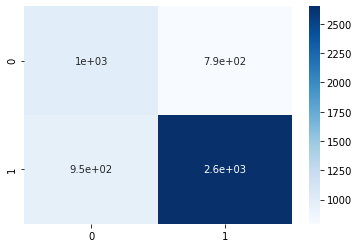

In [ ]:
historical.evaluat_GRU(30,10,11,0.002)

In [ ]:
dfs = pd.read_csv("فملی.csv")

In [ ]:
dfs

id        date  ...  count           stock_id
0           179  2020-09-05  ...  64652  35425587644337450
1           767  2020-09-05  ...  64652  35425587644337450
2          1355  2020-09-05  ...  64652  35425587644337450
3          2190  2020-09-06  ...   1552  35425587644337450
4          2638  2020-09-06  ...   1552  35425587644337450
...         ...         ...  ...    ...                ...
47554  29779295  2021-05-17  ...  11043  35425587644337450
47555  29779869  2021-05-17  ...  11043  35425587644337450
47556  29780443  2021-05-17  ...  11043  35425587644337450
47557  29781017  2021-05-17  ...  11043  35425587644337450
47558  29781591  2021-05-17  ...  11043  35425587644337450

[47559 rows x 13 columns]

In [ ]:
closing_price= dfs['last_price']
label=labeling(dfs['last_price'],0.1)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['date'][10:43000], y=dfs['last_price'][10:43000]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['date'][10:43000], y=label[10:43000])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=500,train_index_end=30000,test_index_end=40000)

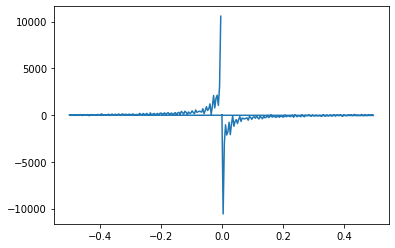

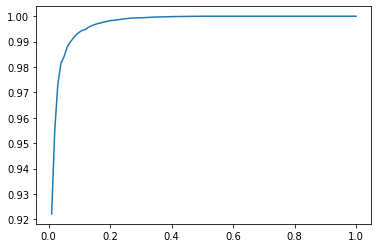

In [ ]:
a,b= historical.fft_analyse()

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=4,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1842/1842 [==============================] - 9s 4ms/step - loss: 0.6510 - accuracy: 0.6404
Epoch 2/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6293 - accuracy: 0.6541
Epoch 3/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6229 - accuracy: 0.6558
Epoch 4/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6184 - accuracy: 0.6547
Epoch 5/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6240 - accuracy: 0.6507
Epoch 6/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6238 - accuracy: 0.6530
Epoch 7/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6266 - accuracy: 0.6511
Epoch 8/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6201 - accuracy: 0.6558
Epoch 9/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.6512 - accuracy: 0.6410
Epoch 10/10
1842/1842 [==============================] - 8s 4ms/step - loss: 0.650

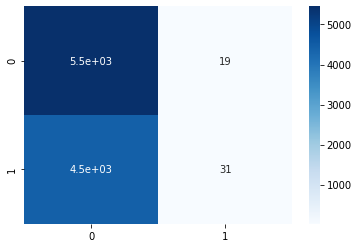

In [ ]:
historical.evaluat_GRU(10,10,11,0.02)

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test_with_smothing(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

In [ ]:
historical.evaluat_GRU(10,20,11,0.002,True)

Epoch 1/50
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6228 - accuracy: 0.6677 - val_loss: 0.6656 - val_accuracy: 0.5897
Epoch 2/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.6042 - accuracy: 0.6824 - val_loss: 0.6644 - val_accuracy: 0.5920
Epoch 3/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5990 - accuracy: 0.6858 - val_loss: 0.6483 - val_accuracy: 0.6192
Epoch 4/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5895 - accuracy: 0.6885 - val_loss: 0.6681 - val_accuracy: 0.6021
Epoch 5/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5790 - accuracy: 0.6947 - val_loss: 0.6458 - val_accuracy: 0.6497
Epoch 6/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5743 - accuracy: 0.6954 - val_loss: 0.6730 - val_accuracy: 0.5808
Epoch 7/50
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5710 - accuracy: 0.6993 - val_loss: 0.6511 - val_ac

KeyboardInterrupt: ignored

In [ ]:
#epoch , layer_size , window_size,lr
historical.prepar_trian_test(step_size=9,deep=True , one_d=True)
#historical.evaluat_LSTM(10,10,11,0.002)

Epoch 1/10
1838/1838 [==============================] - 13s 6ms/step - loss: 0.6203 - accuracy: 0.6683 - val_loss: 0.6618 - val_accuracy: 0.5861
Epoch 2/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6056 - accuracy: 0.6798 - val_loss: 0.6731 - val_accuracy: 0.5813
Epoch 3/10
1838/1838 [==============================] - 11s 6ms/step - loss: 0.6026 - accuracy: 0.6817 - val_loss: 0.6481 - val_accuracy: 0.6177
Epoch 4/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.6008 - accuracy: 0.6827 - val_loss: 0.6712 - val_accuracy: 0.5802
Epoch 5/10
1838/1838 [==============================] - 10s 6ms/step - loss: 0.5982 - accuracy: 0.6853 - val_loss: 0.6567 - val_accuracy: 0.6073
Epoch 6/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5872 - accuracy: 0.6909 - val_loss: 0.6444 - val_accuracy: 0.6360
Epoch 7/10
1838/1838 [==============================] - 10s 5ms/step - loss: 0.5748 - accuracy: 0.6985 - val_loss: 0.6677 - val_ac

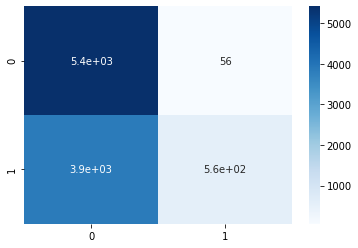

In [ ]:
historical.evaluat_GRU(10,20,11,0.002,True)


In [ ]:
dfs = pd.read_csv("HistoricalData_1627497050412.csv")
dfs = dfs[::-1].reset_index()

In [ ]:
dfs

index        Date  Close/Last Volume     Open     High      Low
0      2556  07/28/2011     1300.67     --  1304.84  1316.32  1299.16
1      2555  07/29/2011     1292.28     --  1300.12  1304.16  1282.86
2      2554  08/01/2011     1286.94     --  1292.59  1307.38  1274.73
3      2553  08/02/2011     1254.05     --  1286.56  1286.56  1254.03
4      2552  08/03/2011     1260.34     --  1254.25  1261.20  1234.56
...     ...         ...         ...    ...      ...      ...      ...
2552      4  07/21/2021     4358.69     --  4331.13  4359.70  4331.13
2553      3  07/22/2021     4367.48     --  4361.27  4369.87  4350.06
2554      2  07/23/2021     4411.79     --  4381.20  4415.18  4381.20
2555      1  07/26/2021     4422.30     --  4409.58  4422.73  4405.45
2556      0  07/27/2021     4401.46     --  4416.38  4416.38  4372.51

[2557 rows x 7 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

In [ ]:
closing_price= dfs['Close/Last']
label=labeling(dfs['Close/Last'],0.15)   
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfs['Date'][10:2350], y=dfs['Close/Last'][10:2350]))
fig.show()
fig = go.Figure([go.Scatter(x=dfs['Date'][10:2350], y=label[10:2350])])
fig.show()

In [ ]:
historical = Train_data(closing_price,label,train_index_start=10,train_index_end=1800,test_index_end=2350)

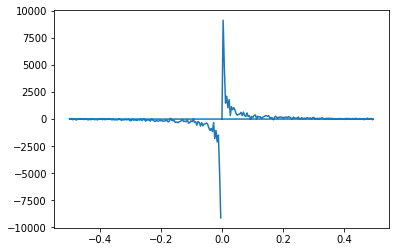

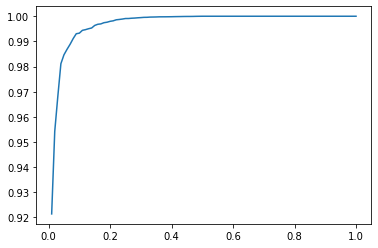

In [ ]:
a,b = historical.fft_analyse()

In [ ]:
def  buy_and_hold(pric , pred , index):
  i = 0
  for i,p in enumerate(pred):
    if p == 1 :
      break
  value = pric[index + i]
  a = 0 
  a=value
  i +=1
  for j in range(len(pred) - i):
    if pred[i + j] == 1:
      value = pric[i+j + index]
  return value / a  




In [ ]:
res1

[['LSTM',
  0.6932103939647947,
  0.7267525035765379,
  0.7437774524158126,
  0.7351664254703328,
  0.06980767426578705],
 ['GRU',
  0.694048616932104,
  0.7256385998107853,
  0.7486578818936066,
  0.7369685323084315,
  0.07014179124221728],
 ['XGBoost',
  0.6962838781782621,
  0.7294847328244275,
  0.7462176671547096,
  0.7377563329312424,
  0.07227621154066724],
 ['LSTM with 44 previous data',
  0.7340665538635082,
  0.7902023429179978,
  0.7299557304476144,
  0.7588851956021478,
  0.11227870960178662],
 ['GRU with 44 previous data',
  0.748448956570784,
  0.7532179316466933,
  0.8347270044269552,
  0.7918805412972468,
  0.11842825438932753],
 ['XGBoost with 44 previous data',
  0.7382966723068246,
  0.7921734531993654,
  0.7368421052631579,
  0.763506625891947,
  0.11610717913741953]]

In [ ]:
Result

MI                          Model  ...        f1     recal
0   0.060884                           LSTM  ...  0.679612  0.752688
1   0.065144                            GRU  ...  0.685990  0.763441
2   0.045411                        XGBoost  ...  0.678223  0.841398
3   0.096797     LSTM with 44 previous data  ...  0.670750  0.608333
4   0.112927      GRU with 44 previous data  ...  0.724044  0.736111
5   0.105471  XGBoost with 44 previous data  ...  0.718157  0.736111
6   0.046708                           LSTM  ...  0.573770  0.577558
7   0.052866                            GRU  ...  0.593997  0.620462
8   0.045725                        XGBoost  ...  0.511811  0.429043
9   0.075432     LSTM with 44 previous data  ...  0.525060  0.407407
10  0.112439      GRU with 44 previous data  ...  0.663004  0.670370
11  0.098931  XGBoost with 44 previous data  ...  0.628231  0.585185
12  0.069808                           LSTM  ...  0.735166  0.743777
13  0.070142                            GRU  ...  0.736969  0.748658
14  0.072276                        XGBoost  ...  0.737756  0.746218
15  0.112279     LSTM with 44 previous data  ...  0.758885  0.729956
16  0.118428      GRU with 44 previous data  ...  0.791881  0.834727
17  0.116107  XGBoost with 44 previous data  ...  0.763507  0.736842
18  0.071145                           LSTM  ...  0.687692  0.619407
19  0.070769                            GRU  ...  0.684801  0.613876
20  0.075504                        XGBoost  ...  0.695362  0.629462
21  0.098437     LSTM with 44 previous data  ...  0.768697  0.787018
22  0.100376      GRU with 44 previous data  ...  0.714286  0.636410
23  0.111380  XGBoost with 44 previous data  ...  0.724737  0.645538
24  0.042618                           LSTM  ...  0.605215  0.531983
25  0.039876                            GRU  ...  0.593798  0.515458
26  0.053082                        XGBoost  ...  0.676824  0.674840
27  0.115092     LSTM with 44 previous data  ...  0.736577  0.714596
28  0.120306      GRU with 44 previous data  ...  0.758856  0.784590
29  0.106421  XGBoost with 44 previous data  ...  0.718067  0.677157
30  0.060671                           LSTM  ...  0.666667  0.611367
31  0.063594                            GRU  ...  0.694320  0.672811
32  0.059382                        XGBoost  ...  0.674323  0.631336
33  0.062973     LSTM with 44 previous data  ...  0.698738  0.680492
34  0.059685      GRU with 44 previous data  ...  0.642164  0.559140
35  0.071544  XGBoost with 44 previous data  ...  0.688053  0.636969

[36 rows x 7 columns]

## Result

In [ ]:
Result = pd.read_csv("result (1).csv")

In [ ]:
Result.head(20)

MI                          Model Name  ...       acc        f1     recal
0  0.051462                           LSTM  ETH  ...  0.655556  0.728070  0.628788
1  0.044735                            GRU  ETH  ...  0.661111  0.738944  0.654040
2  0.055663                        XGBoost  ETH  ...  0.640741  0.706949  0.590909
3  0.047692                         Logreg  ETH  ...  0.659259  0.734870  0.643939
4  0.069063                            SVM  ETH  ...  0.664815  0.730253  0.618687
5  0.053467     LSTM with 44 previous data  ETH  ...  0.708087  0.793872  0.719697
6  0.075630      GRU with 44 previous data  ETH  ...  0.658777  0.735069  0.606061
7  0.077250  XGBoost with 44 previous data  ETH  ...  0.749507  0.826739  0.765152
8  0.052146   logreg with 44 previous data  ETH  ...  0.676529  0.762319  0.664141
9  0.067438      svm with 44 previous data  ETH  ...  0.719921  0.801120  0.722222

[10 rows x 7 columns]

In [ ]:
Result.to_csv('result_eth.csv', index = False)